In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus :
    try:
        # memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), 'Logical GPUs' )
    except RuntimeError as e:
        print(e)

1 Physical GPUs 1 Logical GPUs


Step 1 is to gather the data. You'll notice that there's a bit of a change here in that the training data needed to be reshaped. That's because the first convolution expects a single tensor containing everything, so instead of 60,000 28x28x1 items in a list, we have a single 4D list that is 60,000x28x28x1, and the same for the test images. If you don't do this, you'll get an error when training as the Convolutions do not recognize the shape.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(tran_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#important !!!
tran_images = tran_images.reshape(60000,28,28,1)
tran_images = tran_images / 255
test_images = test_images.reshape(10000,28,28,1)
test_images = test_images / 255

Next is to define your model. Now instead of the input layer at the top, you're going to add a Convolution. The parameters are:

The number of convolutions you want to generate. Purely arbitrary, but good to start with something in the order of 32
The size of the Convolution, in this case a 3x3 grid
The activation function to use -- in this case we'll use relu, which you might recall is the equivalent of returning x when x>0, else returning 0
In the first layer, the shape of the input data.
You'll follow the Convolution with a MaxPooling layer which is then designed to compress the image, while maintaining the content of the features that were highlighted by the convlution. By specifying (2,2) for the MaxPooling, the effect is to quarter the size of the image. Without going into too much detail here, the idea is that it creates a 2x2 array of pixels, and picks the biggest one, thus turning 4 pixels into 1. It repeats this across the image, and in so doing halves the number of horizontal, and halves the number of vertical pixels, effectively reducing the image by 25%.

You can call model.summary() to see the size and shape of the network, and you'll notice that after every MaxPooling layer, the image size is reduced in this way.

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation= 'relu', input_shape = (28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 128, activation= 'relu'),
    tf.keras.layers.Dense(units= 10, activation= 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [4]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print('\n we reached 99% accuracy so we are canceling the rest of the training')
            self.model.stop_training = True
callbacks = myCallback()

In [5]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics = ['accuracy'])
model.fit(tran_images, train_labels, epochs = 5, callbacks =[callbacks])

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 29s 486us/sample - loss: 0.4465 - accuracy: 0.8379
Epoch 2/5
60000/60000 [==============================] - 27s 455us/sample - loss: 0.2984 - accuracy: 0.8906
Epoch 3/5
60000/60000 [==============================] - 27s 456us/sample - loss: 0.2528 - accuracy: 0.9072
Epoch 4/5
60000/60000 [==============================] - 27s 456us/sample - loss: 0.2203 - accuracy: 0.9190
Epoch 5/5
60000/60000 [==============================] - 27s 452us/sample - loss: 0.1924 - accuracy: 0.9273


In [6]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 2s 243us/sample - loss: 0.2560 - accuracy: 0.9094


[0.25604630644917487, 0.9094]

####  Visualizing the Convolutions and Pooling
This code will show us the convolutions graphically. The print (test_labels[;100]) shows us the first 100 labels in the test set, and you can see that the ones at index 0, index 23 and index 28 are all the same value (9). They're all shoes. Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge. Now, when the DNN is training on that data, it's working with a lot less, and it's perhaps finding a commonality between shoes based on this convolution/pooling combination.

In [7]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


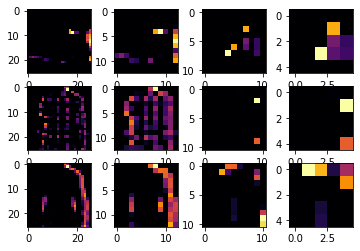

In [10]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=7
THIRD_IMAGE=26
CONVOLUTION_NUMBER = 1
from tensorflow.keras import layers
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)